In [1]:
import numpy as np
from loadmodules import *
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
from numba import njit, config
config.THREADING_LAYER = 'omp'

In [3]:
%matplotlib inline

In [14]:
# simulation_list = [directory for directory in os.listdir('.') if 'Au6_lvl5_13' in directory]
simulation_list = ['Au6_lvl5_1367_k12_fiducial', 'Au6_lvl5_f9742_k12_fiducial']
# print(simulation_list)
# simulation_list = [simulation_list[0], simulation_list[2]]

In [15]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

@njit(parallel=True)
def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    velocity_dispersion = np.std(velocities)
    return velocity_dispersion

In [20]:
def get_mass_functions(simulation, age_young = 1., age_intermediate=6., age_old=10., inner_radius=0., outer_radius=150.,
                       constrain_disk=None ,plot_agedistribution=False, plot_dynamicfriction=False):
    sf = load_subfind(95, dir=simulation+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(95, snappath=simulation+'/output/', subfind=sf, hdf5=True, loadonlyhalo=0)
    s.calc_sf_indizes( sf )
    galrad = 0.1 * sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    s.data['r'] = np.sqrt((s.data['pos']**2).sum(axis=1))
    Gcosmo = 43.
    starparts = s.data['type']==4
    
    kinetic_energy = np.sum(s.data['vel']**2, axis=1)
    # print(kinetic_energy)

    orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
    orbital_energy /= 1e5
    # print(orbital_energy.min(),orbital_energy.max())
    e_max = orbital_energy.max()
    orbital_energy -= e_max
    # print(orbital_energy.min(),orbital_energy.max())
    Jtot = np.sqrt((np.cross( s.data['pos'], (s.data['vel'] ))**2).sum(axis=1))
    Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
    Lz *= np.sign(np.nanmedian(Lz))

    isort_parts = np.argsort(s.data['r'])
    revert_sort = np.argsort(isort_parts)
    cummass = np.cumsum(s.data['mass'][isort_parts])
    Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/s.data['r'])

    # Energy of circular orbits at increasing radii
    Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
    Ecirc /= 1e5
    Ecirc -= e_max
    
    isort_parts = np.argsort(s.data['r'])
    revert_sort = np.argsort(isort_parts)
    cummass = np.cumsum(s.data['mass'][isort_parts])
    Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/s.data['r'])

    mask = mask_equal_to_previous(s.data['r'][isort_parts][~np.isinf(Ecirc)])

    r_test = np.linspace(s.data['r'].min(), s.data['r'].max(),5000)
    Ecirc_f = sp.interpolate.interp1d(s.data['r'][isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask], bounds_error=False, fill_value='extrapolate')
    Vc_f = sp.interpolate.interp1d(s.data['r'][isort_parts][~np.isinf(Ecirc)][mask], Vc_parts[isort_parts][~np.isinf(Ecirc)][mask], bounds_error=False, fill_value='extrapolate')
    Mr_f = sp.interpolate.interp1d(s.data['r'][isort_parts][~np.isinf(Ecirc)][mask], cummass[~np.isinf(Ecirc)][mask], bounds_error=False, fill_value='extrapolate')
    
    mask_clusters_initial = ((s.data['incl'] > 0 ) * (1e3*s.data['r'][starparts] > inner_radius) *
                            (1e3*s.data['r'][starparts] <= outer_radius)) # * (np.abs(1e3*s.data['pos'][starparts,0])>0.2))
    
    idx = np.argmin(np.abs(orbital_energy[starparts][mask_clusters_initial,np.newaxis] - Ecirc_f(r_test)), axis=1)
    rc = r_test[idx]
    vc = Vc_f(rc)
    Lzmax = rc*vc
    circ_param = Lz[starparts][mask_clusters_initial]/Lzmax

    if constrain_disk is None:
        mask_circ_param = np.ones_like(circ_param, dtype=bool)
    elif constrain_disk:
        mask_circ_param = circ_param>=0.8
    else:
        mask_circ_param = circ_param<0.8
    
    cluster_masses = s.data['mclt'][mask_clusters_initial][mask_circ_param].flatten()
    init_cluster_masses = s.data['imcl'][mask_clusters_initial][mask_circ_param].flatten()
    
    not_empty_clusters = (init_cluster_masses>0)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    print('Maximum initial number of clusters per star {:d}'.format(s.data['incl'].max()))
    print('Maximum initial mass {:2.2e} Msun'.format(1e10*init_cluster_masses.max()))
    print('Maximum present-day mass {:2.2e} Msun'.format(1e10*cluster_masses.max()))

    clusters_formtime = np.repeat(s.data['age'][mask_clusters_initial][mask_circ_param], s.data['incl'][mask_clusters_initial][mask_circ_param])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True)

    mask_problematic = s.data['imfc'][mask_clusters_initial][mask_circ_param]>1.
    print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
    print('That`s {:.3f} per cent of stars with clusters'.format(mask_problematic.sum()/len(s.data['imfc'][mask_clusters_initial][mask_circ_param]) * 100))

    if plot_agedistribution:
        plt.hist(clusters_age[cluster_masses>0.], bins=20, histtype='step', density=True)
        plt.xlabel('Cluster`s age [Gyr]')
        plt.ylabel('Age Distribution')
        plt.title(simulation)
        plt.show()
    
    rc_clus = np.repeat(rc[mask_circ_param], s.data['nclt'][mask_clusters_initial][mask_circ_param])
    M_rc_clus = Mr_f(rc[mask_circ_param])
    M_rc_clus = np.repeat(M_rc_clus, s.data['nclt'][mask_clusters_initial][mask_circ_param])
    vc_rc_clus = np.repeat(vc[mask_circ_param], s.data['nclt'][mask_clusters_initial][mask_circ_param])
    sigma_rc_clus = np.array([velocity_dispersion(r, s.data['r'], starparts, s.data['age'], s.data['vel'], s.data['type']) for r in 
                              rc[mask_circ_param][s.data['nclt'][mask_clusters_initial][mask_circ_param]>0]])
    sigma_rc_clus = np.repeat(sigma_rc_clus, s.data['nclt'][mask_clusters_initial][mask_circ_param][s.data['nclt'][mask_clusters_initial][mask_circ_param]>0])

    feps = np.repeat((Jtot[starparts][mask_clusters_initial][mask_circ_param]/Lzmax[mask_circ_param])**0.78, s.data['nclt'][mask_clusters_initial][mask_circ_param])
    coulumblog = np.log(1. + M_rc_clus/cluster_masses[cluster_masses>0.])
    
    tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*cluster_masses[cluster_masses>0.]*coulumblog)
    tdf *= s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s / (1e9*365.25*24*3600)

    mask_disrupted = (tdf < clusters_age[cluster_masses>0.])
    print('Clusters disrupted by dynamical friction {:4d}'.format(mask_disrupted.sum()))
    if(plot_dynamicfriction):
        plt.hist(tdf, bins=np.logspace(-1, 3, 20), histtype='step')
        plt.xscale('log')
        plt.xlabel('Dynamical Friction Timescale [Gyr]')
        plt.ylabel('Number of clusters')
        plt.title(simulation)
        plt.show()

    young_mask = (clusters_age[(cluster_masses>0.)][~mask_disrupted]<age_young)
    intemediate_mask = (clusters_age[(cluster_masses>0.)][~mask_disrupted]>age_intermediate)
    old_mask = (clusters_age[(cluster_masses>0.)][~mask_disrupted]>age_old)

    nbins = 25
    min_gcmf = 1e2 # in solar masses
    max_gcmf = 1e8 # in solar masses
    marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
    width = np.diff(marray_gcmf)

    N,_ = np.histogram(np.log10(1e10*init_cluster_masses), bins=marray_gcmf)
    initial_population = N/width
    N,_ = np.histogram(np.log10(1e10*cluster_masses[(cluster_masses>0.)][~mask_disrupted]), bins=marray_gcmf)
    full_population = N/width
    N,_ = np.histogram(np.log10(1e10*cluster_masses[(cluster_masses>0.)][~mask_disrupted][young_mask]), bins=marray_gcmf)
    young_population = N/width
    N,_ = np.histogram(np.log10(1e10*cluster_masses[(cluster_masses>0.)][~mask_disrupted][intemediate_mask]), bins=marray_gcmf)
    intermediate_population = N/width
    N,_ = np.histogram(np.log10(1e10*cluster_masses[(cluster_masses>0.)][~mask_disrupted][old_mask]), bins=marray_gcmf)
    old_population = N/width

    return [initial_population, full_population, young_population, intermediate_population, old_population]

In [17]:
nbins = 25
min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)

In [18]:
m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
m31_rgc = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=12, delimiter=',')
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(m31_masses[m31_rgc <= 3.], bins=marray_gcmf)
m31_inner_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 3.) * (m31_rgc <= 9.)], bins=marray_gcmf)
m31_intermediate_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 9.)], bins=marray_gcmf)
m31_outer_mass_function = N/width

mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
mw_rgc = mw_catalogue[:,2]
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width
N,_ = np.histogram(mw_masses[mw_rgc <= 3.], bins=marray_gcmf)
mw_inner_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 3.) * (mw_rgc <= 9.)], bins=marray_gcmf)
mw_intermediate_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 9.)], bins=marray_gcmf)
mw_outer_mass_function = N/width

/users/aripcont/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.014036382734775544
Found 18310 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.50


/tmp/ipykernel_2665796/2082878473.py:31: RuntimeWarning: divide by zero encountered in divide
  Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/s.data['r'])
/tmp/ipykernel_2665796/2082878473.py:41: RuntimeWarning: divide by zero encountered in divide
  Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/s.data['r'])


Maximum initial number of clusters per star 12
Maximum initial mass 2.91e+06 Msun
Maximum present-day mass 1.53e+06 Msun
Problematic stars with clusters   31
That`s 0.870 per cent of stars with clusters


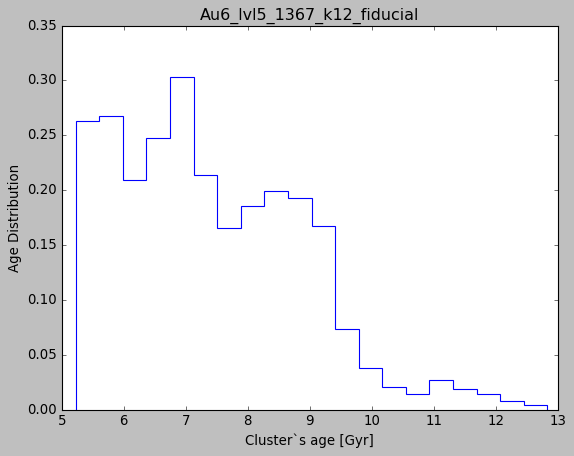

Clusters disrupted by dynamical friction   12


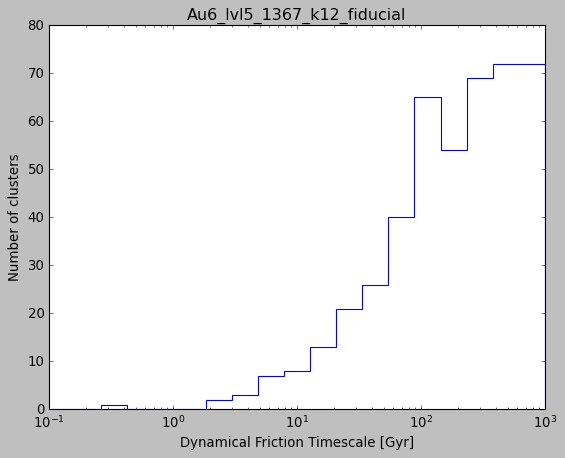

In [21]:
base_init, base_full, base_young, base_intermediate, base_old = get_mass_functions(simulation_list[0], age_young=1.,
                                                                                   constrain_disk=False, plot_agedistribution=True, plot_dynamicfriction=True)

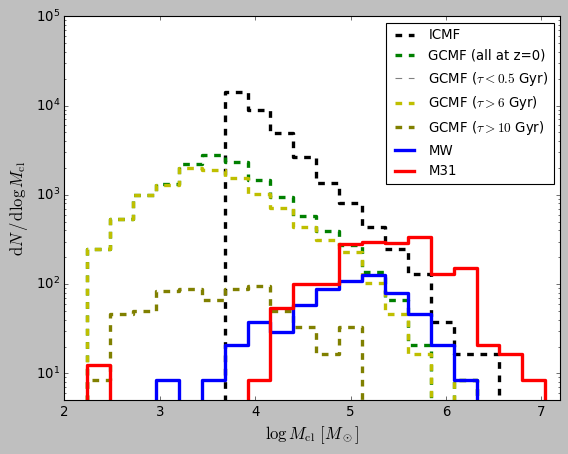

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.step(marray_gcmf[:-1], base_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='ICMF')
ax.step(marray_gcmf[:-1], base_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
ax.step(marray_gcmf[:-1], base_young, where='post',c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau < 0.5$ Gyr)')
ax.step(marray_gcmf[:-1], base_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax.step(marray_gcmf[:-1], base_old, where='post',c='olive', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax.step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='b', label='MW')
ax.step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='r', label='M31')
ax.set_xlim(2,7.2)
ax.set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
ax.set(ylim=(5e0,1e5), yscale= 'log')
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax.tick_params(labelsize=12)
ax.legend(loc='upper right', fontsize=12)
# ax.set_title(r'$\rm{Excluding \; Disk,} \; \epsilon < 0.8$', fontsize=15)
# plt.savefig('plots/'+simulation_list[3]+'_excludingdisk_gcmf_after_df.pdf')

In [23]:
initial_population =[]
full_population = []
young_population = []
intermediate_population = []
old_population = []

In [24]:
for sim in simulation_list:
    init, full, young, intermediate, old = get_mass_functions(sim, age_young=1., constrain_disk=False)
    initial_population.append(init)
    full_population.append(full)
    young_population.append(young)
    intermediate_population.append(intermediate)
    old_population.append(old)

galrad= 0.014036382734775544
Found 18310 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.50


/tmp/ipykernel_2665796/2082878473.py:31: RuntimeWarning: divide by zero encountered in divide
  Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/s.data['r'])
/tmp/ipykernel_2665796/2082878473.py:41: RuntimeWarning: divide by zero encountered in divide
  Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/s.data['r'])


Maximum initial number of clusters per star 12
Maximum initial mass 2.91e+06 Msun
Maximum present-day mass 1.53e+06 Msun
Problematic stars with clusters   31
That`s 0.870 per cent of stars with clusters
Clusters disrupted by dynamical friction   12
galrad= 0.013938993215560913
Found 21973 stars.
Rotated pos.
Rotated bfld.
Rotated vel.
Redshift of the simulation: 0.50
Maximum initial number of clusters per star 12
Maximum initial mass 1.17e+07 Msun
Maximum present-day mass 2.63e+06 Msun
Problematic stars with clusters   37
That`s 0.976 per cent of stars with clusters
Clusters disrupted by dynamical friction   11


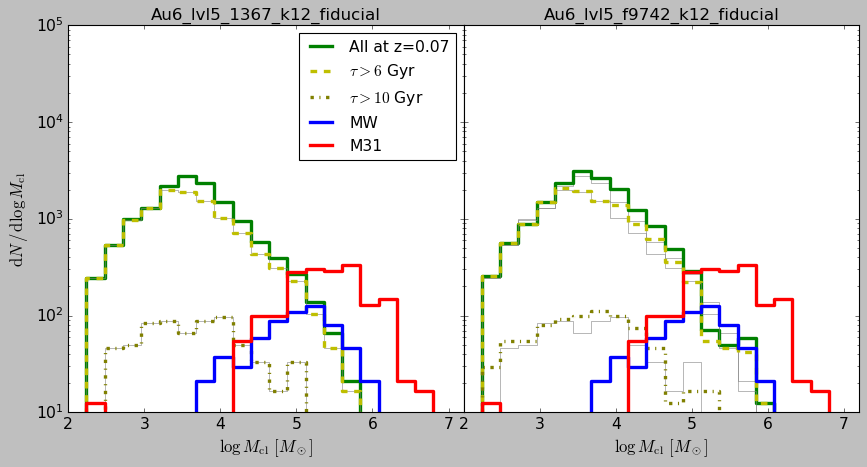

In [25]:
nsubs = 2
fig, ax = plt.subplots(1, nsubs, sharey=True, figsize=(nsubs*5 + 1,6))

for i,mf in enumerate(full_population):
  # if((i+1)%2 == 0):
  ax[i].step(marray_gcmf[:-1], full_population[0], where='post', c='grey', linewidth=0.5)
  ax[i].step(marray_gcmf[:-1], mf, where='post', c='g', linewidth=3, label='All at z=0.07')

for i,mf in enumerate(intermediate_population):
  # if((i+1)%2 == 0):
  ax[i].step(marray_gcmf[:-1], intermediate_population[0], where='post', c='grey', linewidth=0.5)
  ax[i].step(marray_gcmf[:-1], mf, where='post', c='y', linewidth=3, linestyle='--', label=r'$\tau > 6$ Gyr')
  
for i,mf in enumerate(old_population):
  # if((i+1)%2 == 0):
  ax[i].step(marray_gcmf[:-1], old_population[0], where='post', c='grey', linewidth=0.5)
  ax[i].step(marray_gcmf[:-1], mf, where='post', c='olive', linewidth=3, linestyle='-.', label=r'$\tau > 10$ Gyr')

for i in range(len(ax)):
  ax[i].step(marray_gcmf[:-1], mw_mass_function, where='post', linewidth=3, c='b', label='MW')
  ax[i].step(marray_gcmf[:-1], m31_mass_function, where='post', linewidth=3, c='r', label='M31')
  ax[i].set_xlim(2,7.2)
  ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
  ax[i].tick_params(labelsize=14)
  ax[i].set_title(simulation_list[i], fontsize=15)

ax[0].set(ylim=(1e1,1e5), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax[0].legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('plots/evtest_bheffect_gcmf_compare.pdf')

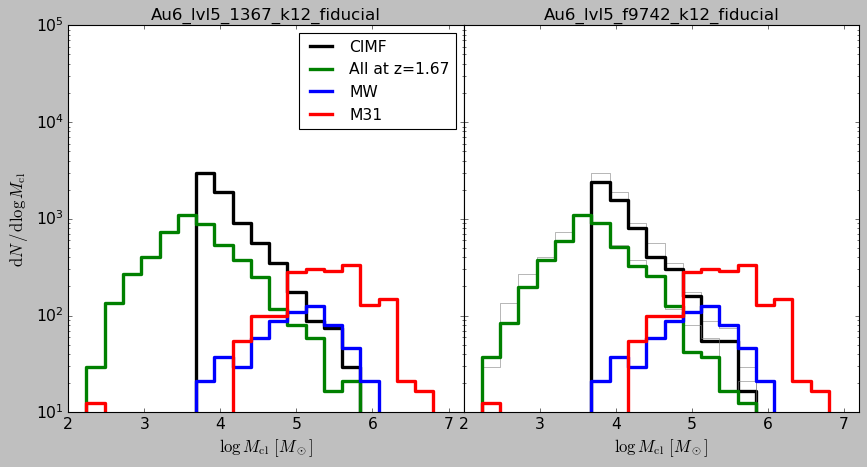

In [24]:
nsubs = 2
fig, ax = plt.subplots(1, nsubs, sharey=True, figsize=(nsubs*5 + 1,6))

for i,mf in enumerate(initial_population):
  # if((i+1)%2 == 0):
  ax[i].step(marray_gcmf[:-1], initial_population[0], where='post', c='grey', linewidth=0.5)
  ax[i].step(marray_gcmf[:-1], mf, where='post', c='k', linewidth=3, label='CIMF')
for i,mf in enumerate(full_population):
  # if((i+1)%2 == 0):
  ax[i].step(marray_gcmf[:-1], full_population[0], where='post', c='grey', linewidth=0.5)
  ax[i].step(marray_gcmf[:-1], mf, where='post', c='g', linewidth=3, label='All at z=1.67')

# for i,mf in enumerate(intermediate_population):
#   # if((i+1)%2 == 0):
#   ax[i].step(marray_gcmf[:-1], intermediate_population[0], where='post', c='grey', linewidth=0.5)
#   ax[i].step(marray_gcmf[:-1], mf, where='post', c='y', linewidth=3, linestyle='--', label=r'$\tau > 6$ Gyr')
  
# for i,mf in enumerate(old_population):
#   # if((i+1)%2 == 0):
#   ax[i].step(marray_gcmf[:-1], old_population[0], where='post', c='grey', linewidth=0.5)
#   ax[i].step(marray_gcmf[:-1], mf, where='post', c='olive', linewidth=3, linestyle='-.', label=r'$\tau > 10$ Gyr')

for i in range(len(ax)):
  ax[i].step(marray_gcmf[:-1], mw_mass_function, where='post', linewidth=3, c='b', label='MW')
  ax[i].step(marray_gcmf[:-1], m31_mass_function, where='post', linewidth=3, c='r', label='M31')
  ax[i].set_xlim(2,7.2)
  ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
  ax[i].tick_params(labelsize=14)
  ax[i].set_title(simulation_list[i], fontsize=15)

ax[0].set(ylim=(1e1,1e5), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax[0].legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('plots/evtest_bheffect_gcmf_compare.pdf')

In [42]:
all_init, all_full, all_young, all_intermediate, all_old = get_mass_functions(simulation_list[3], age_intermediate=6., age_old=10.)
inner_init, inner_full, inner_young, inner_intermediate, inner_old = get_mass_functions(simulation_list[3], outer_radius=3., age_intermediate=6., age_old=10.)
intermediate_init, intermediate_full, intermediate_young, intermediate_intermediate, intermediate_old = get_mass_functions(simulation_list[3], inner_radius=3., outer_radius=9., age_intermediate=6., age_old=10.)
outer_init, outer_full, outer_young, outer_intermediate, outer_old = get_mass_functions(simulation_list[3], inner_radius=9., age_intermediate=6., age_old=10.)

galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.


/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


Maximum initial number of clusters per star 6
Maximum initial mass 2.60e+07 Msun
Maximum present-day mass 1.42e+07 Msun
Problematic stars with clusters 2392
That`s 17.811% of stars with clusters
galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.
Maximum initial number of clusters per star 6
Maximum initial mass 2.14e+07 Msun
Maximum present-day mass 1.06e+07 Msun
Problematic stars with clusters 2392
That`s 24.188% of stars with clusters
galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.
Maximum initial number of clusters per star 6
Maximum initial mass 1.76e+07 Msun
Maximum present-day mass 9.58e+06 Msun
Problematic stars with clusters 2392
That`s 130.071% of stars with clusters
galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.
Maximum initial number of clusters per star 6
Maximum initial mass 2.60e+07 Msun
Maximum present-day mass 1.42e+07 Msun
Problematic stars with clusters 2392
That`s 140.541% of stars with cl

Text(0.5, 0.98, 'Au6_lvl4_aa96_tightconstrain')

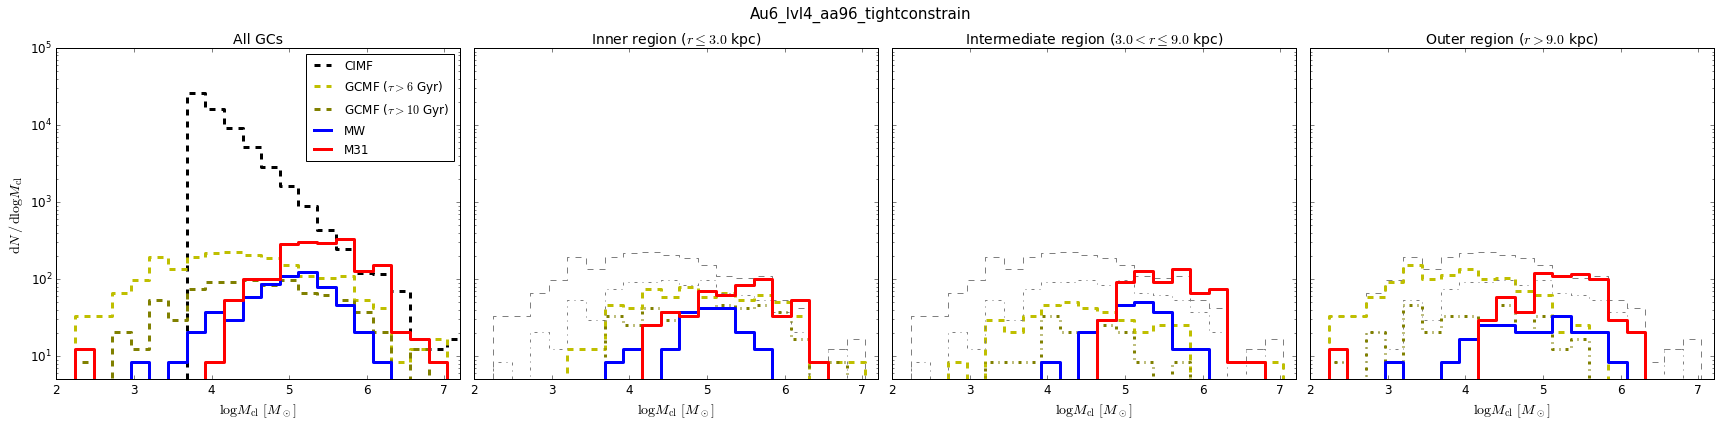

In [43]:
fig, ax = plt.subplots(1,4, figsize=(24,6), sharey=True)

ax[0].step(marray_gcmf[:-1], all_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='CIMF')
# ax[0].step(marray_gcmf[:-1], all_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
ax[0].step(marray_gcmf[:-1], all_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax[0].step(marray_gcmf[:-1], all_old, where='post',c='olive', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax[0].step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='b', label='MW')
ax[0].step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='r', label='M31')
ax[0].set_title('All GCs', fontsize=14)
ax[0].set_xlim(2,7.2)
ax[0].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
ax[0].tick_params(labelsize=12)

# ax[1].step(marray_gcmf[:-1], inner_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='CIMF')
# ax[1].step(marray_gcmf[:-1], inner_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
ax[1].step(marray_gcmf[:-1], all_intermediate, where='post',c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau > 6$ Gyr)')
ax[1].step(marray_gcmf[:-1], inner_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax[1].step(marray_gcmf[:-1], all_old, where='post',c='gray', linestyle='dashdot', linewidth = 1, label=r'GCMF ($\tau > 10$ Gyr)')
ax[1].step(marray_gcmf[:-1], inner_old, where='post',c='olive', linestyle='dashdot', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax[1].step(marray_gcmf[:-1], mw_inner_mass_function, where='post',linewidth=3, c='b', label='MW')
ax[1].step(marray_gcmf[:-1], m31_inner_mass_function, where='post',linewidth=3, c='r', label='M31')
ax[1].set_title(r'Inner region ($r \leq 3.0$ kpc)', fontsize=14)
ax[1].set_xlim(2,7.2)
ax[1].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
ax[1].tick_params(labelsize=12)

# ax[2].step(marray_gcmf[:-1], intermediate_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='CIMF')
# ax[2].step(marray_gcmf[:-1], intermediate_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
ax[2].step(marray_gcmf[:-1], all_intermediate, where='post',c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau > 6$ Gyr)')
ax[2].step(marray_gcmf[:-1], intermediate_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax[2].step(marray_gcmf[:-1], all_old, where='post',c='gray', linestyle='dashdot', linewidth = 1, label=r'GCMF ($\tau > 10$ Gyr)')
ax[2].step(marray_gcmf[:-1], intermediate_old, where='post',c='olive', linestyle='dashdot', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax[2].step(marray_gcmf[:-1], mw_intermediate_mass_function, where='post',linewidth=3, c='b', label='MW')
ax[2].step(marray_gcmf[:-1], m31_intermediate_mass_function, where='post',linewidth=3, c='r', label='M31')
ax[2].set_title(r'Intermediate region ($3.0 < r \leq 9.0$ kpc)', fontsize=14)
ax[2].set_xlim(2,7.2)
ax[2].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
ax[2].tick_params(labelsize=12)

# ax[3].step(marray_gcmf[:-1], outer_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='CIMF')
# ax[3].step(marray_gcmf[:-1], outer_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
ax[3].step(marray_gcmf[:-1], all_intermediate, where='post',c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau > 6$ Gyr)')
ax[3].step(marray_gcmf[:-1], outer_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax[3].step(marray_gcmf[:-1], all_old, where='post',c='gray', linestyle='dashdot', linewidth =1, label=r'GCMF ($\tau > 10$ Gyr)')
ax[3].step(marray_gcmf[:-1], outer_old, where='post',c='olive', linestyle='dashdot', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax[3].step(marray_gcmf[:-1], mw_outer_mass_function, where='post',linewidth=3, c='b', label='MW')
ax[3].step(marray_gcmf[:-1], m31_outer_mass_function, where='post',linewidth=3, c='r', label='M31')
ax[3].set_title(r'Outer region ($r > 9.0$ kpc)', fontsize=14)
ax[3].set_xlim(2,7.2)
ax[3].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
ax[3].tick_params(labelsize=12)


ax[0].set(ylim=(5e0,1e5), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=14)
ax[0].legend(loc='upper right', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle(simulation_list[3], fontsize=15)
# plt.savefig('plots/f1_2_shboost_gcmf_radialbins.pdf')